In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Second-order advection

To get a more accurate solution, we need to handle both the space and time discretizations in a higher order fashion.

First, let's look again at the definition of the average:

$$\langle a \rangle_i = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} a(x) dx$$

let's substitute in a Taylor expansion about $x_i$:

$$a(x) = a(x_i) + \left . \frac{\partial a}{\partial x} \right |_i (x - x_i) + \frac{1}{2} \left . \frac{\partial^2 a}{\partial x^2} \right |_i (x - x_i)^2 + \mathcal{O}(\Delta x^3)$$

inserting this into our integral, we have:

$$\langle a \rangle_i = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} 
    \left [a(x_i) + \left . \frac{\partial a}{\partial x} \right |_i (x - x_i) + \frac{1}{2} \left . \frac{\partial^2 a}{\partial x^2} \right |_i (x - x_i)^2 + \mathcal{O}(\Delta x^3) \right ] dx$$

Look at the terms:

* the first term is just a constant, so it's integral is just $a(x_i) \Delta x$
* the second term is odd over the interface $[x_{i-1/2},x_{i+1/2}]$, so it integrates to 0
* the third term will integrate to something like $(\Delta x)^3$ (before we divide by the $\Delta x$ out front)

This means that

$$\langle a \rangle_i = a(x_i) + \mathcal{O}(\Delta x^2)$$

So if we work to second-order in space, then we don't need to worry about the difference between the cell average and cell-center.  

To make the notation easier, we'll drop the $\langle \rangle$ from now forward.

There are 2 broad ways that we can handle the time integration to get more accuracy:

* Predict our interface states at the midpoint in time using a Taylor expansion (in both space and time).  This would result in a time-centered interface state.  This procedure is sometimes called *characteristic tracing*.  

* Just construct high-order interface states in space, ignoring how they evolve in time, and use a high-order integrator (like Runge-Kutta) to handle the time integration.  This is called the *method-of-lines* approach.

We'll focus on the second approach (method-of-lines).  For details on the first, see my notes: [Computational Hydrodynamics for Astrophysics](https://github.com/Open-Astrophysics-Bookshelf/numerical_exercises)

## Piecewise linear reconstruction

For the first order method, we did the reconstruction to the interfaces by assuming that $a(x)$ is constant in a cell.  This is called *piecewise constant reconstruction*.

To be higher-order accurate, we need to allow for some variation in the zone.  The next easiest approach is to allow $a(x)$ to vary linearly in the zone.  This is called *piecewise linear reconstruction*. 

![piecewise linear reconstruction](riemann-mol.png)

In the figure above, the cell-average is represented by the dotted gray line and the reconstructed slopes, $\Delta a_i$, are the red solid lines.  We can use a centered-difference for the slope, e.g.,

$$\Delta a_i = \frac{a_{i+1} - a_{i-1}}{2}$$

Our reconstructed form of $a(x)$ in this case is:

$$a(x) = \frac{\Delta a_i}{\Delta x} (x - x_i) + a_i$$

and this is conservative, e.g.,

$$\frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} a(x) dx = a_i$$

Then we construct the interface states by following this slope from the value $a_i$ at $x_i$ to the two interfaces for that zone.  Note that zone $i$ connects to the right state on the left interface ($i-1/2$) and the left state on the right interface ($i+1/2$):

![advection states](advection-states.png)

Therefore, we have:

$$a_{i-1/2,R} = a(x_i - \Delta x/2) = a_i - \frac{1}{2} \Delta a_i$$

$$a_{i+1/2,L} = a(x_i + \Delta x/2) = a_i + \frac{1}{2} \Delta a_i$$

There is one additional complication: we need the interface state just outside the physical domain, which means that we need to construct a slope there, which in turn means that we need to have an additional ghost cell to allow us to compute the centered-difference slope.  So for this method, we need 2 ghost cells on each side.

![ghost cells in the finite-volume method](fv_ghost.png)

## Implementation

To start, we need a class that hold the data on a finite-volume grid and knows how to fill ghost cells on *any array* that lives on our domain.

In [3]:
class FVGrid:

    def __init__(self, nx, ng=2, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered, left and right edges
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx
        self.xl = xmin + (np.arange(nx+2*ng)-ng)*self.dx
        self.xr = xmin + (np.arange(nx+2*ng)-ng+1.0)*self.dx

        # storage for the solution
        self.a = self.scratch_array()
        self.ainit = self.scratch_array()

    def period(self, u):
        """ return the period for advection with velocity u """
        return (self.xmax - self.xmin) / np.abs(u)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all ghostcells with periodic boundary conditions """

        # left boundary
        for n in range(self.ng):
            atmp[self.ilo-1-n] = atmp[self.ihi-n]

        # right boundary
        for n in range(self.ng):
            atmp[self.ihi+1+n] = atmp[self.ilo+n]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))
    
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x, self.ainit, label="initial conditions")
        ax.plot(self.x, self.a)
        ax.legend()
        return fig

Now, we'll use 2nd order Runge-Kutta.  If we use the implementation ideas from before, then we want a RHS function that we can call that just gives us the update.  Here we are thinking of our equation as:

$$\dot{y}_i = g(y_i)$$

where 

$$g(y_i) = -\frac{1}{\Delta x} \left [ F(a_{i+1/2}) - F(a_{i-1/2}) \right ]$$

We need to store interface values (which we've been denoting with half-integer subscripts, like $a_{i-1/2}$) as arrays which only take integer indices.  We will adopt the common convention that when an array refers to an interface state, it denotes the left interface of a cell.

E.g., `aint[i]}` means $a_{i-1/2}$

This is illustrated below for arrays `a[]` which stores cell center quantities and `aint[]` which stores interface values:

![array notation for interfaces](array-labels.png)

In [20]:
def flux_update(gr, u, a):
    """compute -div{F} for linear advection"""

    # slope
    da = gr.scratch_array()
    da[gr.ilo-1:gr.ihi+2] = 0.5*(a[gr.ilo:gr.ihi+3] - a[gr.ilo-2:gr.ihi+1])

    # upwinding means that we take the left state always
    # convection: aint[i] = a_{i-1/2}
    aint = gr.scratch_array()
    aint[gr.ilo:gr.ihi+2] = a[gr.ilo-1:gr.ihi+1] + 0.5*da[gr.ilo-1:gr.ihi+1]

    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = u * (aint[gr.ilo:gr.ihi+1] - aint[gr.ilo+1:gr.ihi+2]) / gr.dx

    return flux_diff

Now we write the time update.  This is going to look a lot what we did with orbits.  The main thing we need to remember is that we need to fill the ghost cells before we compute the RHS

In [21]:
def advection_mol(nx, u, C, num_periods=1, init_cond=None):

    # create a grid
    g = FVGrid(nx, ng=2)

    tmax = num_periods * g.period(u)

    # setup initial conditions
    init_cond(g)

    g.ainit[:] = g.a[:]
    
    # compute the timestep
    dt = C * g.dx / np.abs(u)

    t = 0.0
    while t < tmax:

        if t + dt > tmax:
            dt = tmax - t

        # second-order RK integration
        g.fill_BCs(g.a)
        k1 = flux_update(g, u, g.a)

        atmp = g.scratch_array()
        atmp[:] = g.a[:] + 0.5 * dt * k1[:]

        g.fill_BCs(atmp)
        k2 = flux_update(g, u, atmp)

        g.a[:] += dt * k2[:]

        t += dt

    return g

In [6]:
def tophat(g):
    g.a[:] = 0.0
    g.a[np.logical_and(g.x >= 1./3, g.x <= 2./3.)] = 1.0

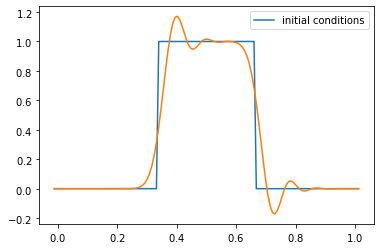

In [10]:
C = 0.5
u = 1.0
nx = 128

g = advection_mol(nx, u, C, init_cond=tophat)
fig = g.plot()

<div class="alert alert-block alert-info">

**Exercise:**
    
Implement initial conditions corresponding to a Gaussian and run the solver with these initial conditions&mdash;how do they compare?
    
</div>

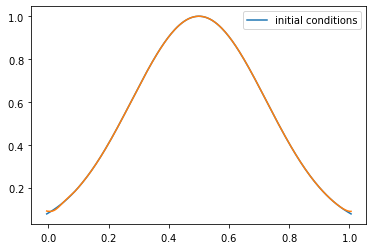

In [19]:
def gaussian(g):
    g.a[:] = np.exp(-(g.x - 0.5)**2/0.1)
    
g = advection_mol(nx, u, C, init_cond=gaussian)
fig = g.plot()

One thing you'll notice is that with tophat initial conditions, there are oscillations near the discontinuities.  We don't see these with the smooth run.

Godunov's theorem says:

  > *Any monotonic linear method for advection is first order accurate*
   
and the converse is true as well.  This means that in order to be monotonic and second-order accurate, we need to make our method nonlinear.

This is accomplished through the use of slope limiters.  A limiter modifies the piecewise linear slopes near extrema to prevent overshoots.  Mathematically they enforce a property called *total variation diminshing*.

A simple limiter is the *minmod limiter*:

$$\Delta a_i = \mathtt{minmod} \left (
  {a_i - a_{i-1}}, {a_{i+1} - a_i} \right )$$

with:

$$
\mathtt{minmod}(a,b) = \left \{
    \begin{array}{ll}
    a & \mathit{if~} |a| < |b| \mathrm{~and~} a\cdot b > 0 \\
    b & \mathit{if~} |b| < |a| \mathrm{~and~} a\cdot b > 0 \\
    0 & \mathit{otherwise}
    \end{array}
  \right .
$$

Most limiters have a form like this.  The key is the check $a \cdot b > 0$.  That is checking if the slopes on the left and right of the interface are the same sign.  If they are not the same sign, then we are at an extrema (a minimum or maximum) and those are the situations where we want to limit.

Here's a visualization of the effect of the limiter:

![limited slopes](generalgrid.png)

The gray lines are the original unlimited slopes.  Notice that the slope at $i - 2$ goes well above the original data on the right edge of the domain.  That zone is a maximum.  The limited slopes are shown in red.  For zone $i-2$ the result of the limiting is to completely flatten the profile&mdash;we go to piecewise constant in that zone.

<div class="alert alert-block alert-info">

**Exercise:**
    
Adapt the second-order advection code to limit the slopes using the ``minmod`` limtier and rerun the Gaussian and tophat initial conditions.
    
</div>

In [27]:
def flux_update(gr, u, a):
    """compute -div{F} for linear advection"""

    # slope
    
    # dl = a_i - a_{i-1}
    dl = gr.scratch_array()
    dl[gr.ilo-1:gr.ihi+2] = a[gr.ilo-1:gr.ihi+2] - a[gr.ilo-2:gr.ihi+1]

    # dr = a_{i+1} - a_i
    dr = gr.scratch_array()
    dr[gr.ilo-1:gr.ihi+2] = a[gr.ilo:gr.ihi+3] - a[gr.ilo-1:gr.ihi+2]
    
    d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
    da = np.where(dl*dr > 0.0, d1, 0.0)
    
    # upwinding means that we take the left state always
    # convection: aint[i] = a_{i-1/2}
    aint = gr.scratch_array()
    aint[gr.ilo:gr.ihi+2] = a[gr.ilo-1:gr.ihi+1] + 0.5*da[gr.ilo-1:gr.ihi+1]

    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = u * (aint[gr.ilo:gr.ihi+1] - aint[gr.ilo+1:gr.ihi+2]) / gr.dx

    return flux_diff

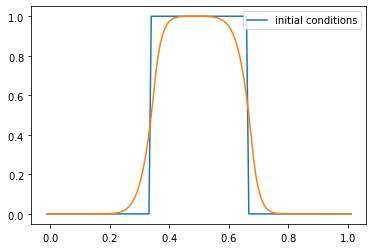

In [15]:
C = 0.5
u = 1.0
nx = 128

g = advection_mol(nx, u, C, init_cond=tophat)
fig = g.plot()

<div class="alert alert-block alert-info">

**Exercise:**
    
Now let's see if we are really second-order accurate.  Compute the norm of the error after 1 period with and without the limiters for the sine initial conditions used previous.  Does it converge 2nd order?
    
</div>

In [25]:
def sine(g):
    g.a[:] = 1.0 + 0.5 * np.sin(2.0*np.pi*g.x)

In [28]:
u = 1.0
C = 0.5

for nx in [32, 64, 128, 256]:
    g = advection_mol(nx, u, C, init_cond=sine)
    print(f"{nx:3d}: {g.norm(g.a - g.ainit):10.8f}")

 32: 0.03721840
 64: 0.01323005
128: 0.00421420
256: 0.00132975
